In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
try:
  from keras import datasets, layers, models, Sequential
except:
  !python -m pip install keras
  from keras import datasets, layers, models, Sequential
try:
  from scikeras.wrappers import KerasClassifier, KerasRegressor
except ImportError:
    !python -m pip install scikeras
    from scikeras.wrappers import KerasClassifier, KerasRegressor
  

from datetime import datetime

import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=100000, precision=3)
import sys
import pandas as pd

from skimage import data, io, filters
from skimage.transform import resize
from skimage.transform import rotate

from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

In [2]:
print(tf.__version__)

2.8.0


### TPU

In [12]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.84.162.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.84.162.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [13]:
try:
  import os
  device_name = os.environ["COLAB_TPU_ADDR"]
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

Found TPU at: grpc://10.84.162.50:8470


In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14813923337054239589
xla_global_id: -1
]


### GPU

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Code

In [3]:
(img_train, label_train), (img_test, label_test) = tfds.as_numpy(tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=True,
))

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [8]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

In [9]:
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.84.162.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.84.162.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [10]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#Using a NNet for classification

### Prelude
- The data is in the form of a 28x28 matrix that contains the greyscale pixel of an object. To use it for a Neural network, we will apply convolution to it  and then pool it into a smaller matrix as the data procesing step i.e. we will use a CNN. In addition to that, we normalize the image's pixel values to be a number between 0 and 1 by dividing by 255

In [11]:
img_train = img_train / 255
img_test = img_test / 255

#### CNN with Maxpooling

In [ ]:
model = models.Sequential() # Create the model
model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
model.add(layers.Conv2D(56, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool
model.add(layers.Conv2D(112, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(112, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 56)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 3, 3, 112)         56560     
                                                                 
 flatten_4 (Flatten)         (None, 1008)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(img_train, label_train, epochs=10, 
                    validation_data=(img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4645 - accuracy: 0.8290 - val_loss: 0.3538 - val_accuracy: 0.8748
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3060 - accuracy: 0.8878 - val_loss: 0.3024 - val_accuracy: 0.8935
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2578 - accuracy: 0.9036 - val_loss: 0.2762 - val_accuracy: 0.8996
Epoch 4/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2280 - accuracy: 0.9153 - val_loss: 0.2670 - val_accuracy: 0.9066
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2009 - accuracy: 0.9246 - val_loss: 0.2764 - val_accuracy: 0.9033
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1806 - accuracy: 0.9326 - val_loss: 0.2612 - val_accuracy: 0.9103
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1584 - accuracy: 0.9391 - val_loss: 0.2539 - val_accuracy:

In [ ]:
model.layers[0].filters

28

313/313 - 1s - loss: 0.3055 - accuracy: 0.9088 - 644ms/epoch - 2ms/step


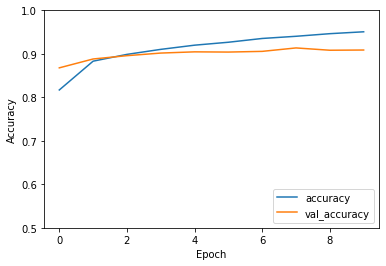

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(img_test,  label_test, verbose=2)

#### CNN with avgerage pooling

In [ ]:
model = models.Sequential() # Create the model
model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
model.add(layers.AveragePooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
model.add(layers.Conv2D(56, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D(pool_size = (2, 2))) #pool
model.add(layers.Conv2D(112, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(112, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 average_pooling2d (AverageP  (None, 13, 13, 28)       0         
 ooling2D)                                                       
                                                                 
 conv2d_22 (Conv2D)          (None, 11, 11, 56)        14168     
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 56)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 3, 112)         56560     
                                                                 
 flatten_5 (Flatten)         (None, 1008)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(img_train, label_train, epochs=10, 
                    validation_data=(img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5356 - accuracy: 0.8013 - val_loss: 0.4099 - val_accuracy: 0.8488
Epoch 2/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3531 - accuracy: 0.8699 - val_loss: 0.3455 - val_accuracy: 0.8761
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3015 - accuracy: 0.8893 - val_loss: 0.3091 - val_accuracy: 0.8864
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2690 - accuracy: 0.8999 - val_loss: 0.2922 - val_accuracy: 0.8943
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2445 - accuracy: 0.9086 - val_loss: 0.2633 - val_accuracy: 0.9039
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2242 - accuracy: 0.9164 - val_loss: 0.2848 - val_accuracy: 0.8965
Epoch 7/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2051 - accuracy: 0.9232 - val_loss: 0.2664 - val_accuracy:

313/313 - 1s - loss: 0.2849 - accuracy: 0.9071 - 640ms/epoch - 2ms/step


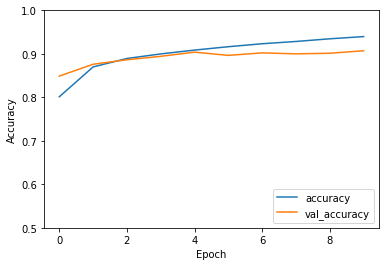

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(img_test,  label_test, verbose=2)

### Data Augmentation

In [12]:
augmented_data = []
augmented_data_ys = []
for i,img in enumerate(img_train):
  #rotate 90 degrees
  # augmented_data.append(rotate(img,90))
  # augmented_data_ys.append(label_train[i])

  # #rotate 180 degrees
  # augmented_data.append(rotate(img,180))
  # augmented_data_ys.append(label_train[i])

  # #rotate 270 degrees
  # augmented_data.append(rotate(img,270))
  # augmented_data_ys.append(label_train[i])

  #flip left to right
  augmented_data.append(np.fliplr(img))
  augmented_data_ys.append(label_train[i])

In [13]:
augmented_data = np.array(augmented_data)
augmented_data_ys = np.array(augmented_data_ys)
img_train = np.concatenate((img_train,augmented_data))
print(img_train.shape)
label_train = np.concatenate((label_train,augmented_data_ys))
print(label_train.shape)

img_train, label_train = shuffle(img_train, label_train, random_state=0)

(120000, 28, 28, 1)
(120000,)


### CNN with augmented data and GridSearchCV




In [37]:
# Function to create model, required for KerasClassifier
def create_model(conv_layers, filter_shape, filters_start,  nn_layers, activation='relu' , optimizer='adam'):
  with strategy.scope():
    model = models.Sequential() # Create the model
    filters_num = filters_start
    for i in range(conv_layers):
      model.add(layers.Conv2D(filters_num, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
      model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
      filters_num *= 2
    for i in range(nn_layers):
      model.add(layers.Flatten())
      model.add(layers.Dense(filters_num, activation=activation))
      model.add(layers.Dense(10)) #output layer
      
    model.compile(optimizer=optimizer,
                steps_per_execution = 50,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [27]:
df_results = pd.DataFrame({"hyperparams": [], "average_kfold_accuracy": [] })

In [32]:
activation = ['relu'] #'tanh', 'sigmoid']
#convnet are sensitive to batch_size and epochs so do grid search on those too
batch_size = [32] #cant try more due to limited ram so use default
epochs = [5, 10, 15]
conv_layers = [2,3]
filter_shapes = [(3,3)]#,(5,5),(7,7)]
filters_start = [30,50, 70]
nn_layers = [1,2]
splits = 3

for act in activation:
  for bs in batch_size:
    for epoch in epochs:
      for conv_layer in conv_layers:
        for filter_shape in filter_shapes:
          for nn in filters_start:
            for nl in nn_layers:
              hyperparams = {'activation' : act, "optimizer": "adam", "batch_size": bs, "epochs": epoch, "conv_layers": conv_layer,
                         "filter_shapes": filter_shape, "nodes_num": nn, "nn_layers": nl}
              print(hyperparams)

              # checkpoint_filepath = f'/content/gdrive/MyDrive/Colab Notebooks/CS273A_project/tmp/checkpoint/{act}_{bs}_{epoch}_{conv_layer}_{filter_shape}_{nn}_{nl}/{act}_{bs}_{epoch}_{conv_layer}_{filter_shape}_{nn}_{nl}.ckpt'
              # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
              #     filepath=checkpoint_filepath,
              #     save_weights_only=True,
              #     monitor='val_accuracy',
              #     mode='max',
              #     save_best_only=True,
              #     verbose=2)
              kf = KFold(n_splits=splits)
              avg_kfold = np.zeros(splits)
              i = 0
              for train_index, test_index in kf.split(img_train):
                clf = create_model(conv_layer, filter_shape, nn,  nl, activation=act , optimizer='adam')
                clf.summary()
                X_train, X_test = img_train[train_index], img_train[test_index]
                y_train, y_test = label_train[train_index], label_train[test_index]
                history = clf.fit(img_train, label_train, epochs=epoch,batch_size = bs,
                    validation_data=(img_test, label_test))
                avg_kfold[i] = np.array(history.history['accuracy']).mean()
                i+=1
              
              result = {"hyperparams": [str(hyperparams)], "average_kfold_accuracy": [avg_kfold.mean()]}
                
              df = pd.DataFrame(result)

              df_results = df_results.append(df)
              df_results.to_csv(f"convnet_results_{datetime.now()}.csv")

Streaming output truncated to the last 5000 lines.
Epoch 2/5
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3224 - accuracy: 0.8808 - val_loss: 0.3374 - val_accuracy: 0.8774
Epoch 3/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.2741 - accuracy: 0.8983 - val_loss: 0.3200 - val_accuracy: 0.8874
Epoch 4/5
3750/3750 [==============================] - 11s 3ms/step - loss: 0.2456 - accuracy: 0.9080 - val_loss: 0.2867 - val_accuracy: 0.8934
Epoch 5/5
3750/3750 [==============================] - 11s 3ms/step - loss: 0.2232 - accuracy: 0.9156 - val_loss: 0.3114 - val_accuracy: 0.8896
{'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'epochs': 5, 'conv_layers': 3, 'filter_shapes': (3, 3), 'nodes_num': 30, 'nn_layers': 2}
filters_num: 60
filters_num: 120
filters_num: 240
done with conv layers
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param 

In [33]:
display(df_results)

,hyperparams,average_kfold_accuracy
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.908253
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.902183
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.917261
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.911496
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.922121
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.915418
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.882698
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.878076
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.892650
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.886521


In [ ]:
yhat = clf.predict(img_test)
yhat_class = np.argmax(yhat,axis=1)

#### Do Grid search CV again but this time add val accuracy

In [34]:
df_results_with_val_error = pd.DataFrame({"hyperparams": [], "average_kfold_accuracy": [], "average_val_accuracy": [] })

In [38]:
activation = ['relu'] #'tanh', 'sigmoid']
#convnet are sensitive to batch_size and epochs so do grid search on those too
batch_size = [32] #cant try more due to limited ram so use default
epochs = [5, 10, 15]
conv_layers = [2,3]
filter_shapes = [(3,3)]#,(5,5),(7,7)]
filters_start = [30,50, 70]
nn_layers = [1,2]
splits = 3

for act in activation:
  for bs in batch_size:
    for epoch in epochs:
      for conv_layer in conv_layers:
        for filter_shape in filter_shapes:
          for nn in filters_start:
            for nl in nn_layers:
              hyperparams = {'activation' : act, "optimizer": "adam", "batch_size": bs, "epochs": epoch, "conv_layers": conv_layer,
                         "filter_shapes": filter_shape, "nodes_num": nn, "nn_layers": nl}
              kf = KFold(n_splits=splits)
              avg_kfold_train = 0
              avg_kfold_val = 0
              for train_index, test_index in kf.split(img_train):
                clf = create_model(conv_layer, filter_shape, nn,  nl, activation=act , optimizer='adam')
                X_train, X_test = img_train[train_index], img_train[test_index]
                y_train, y_test = label_train[train_index], label_train[test_index]
                history = clf.fit(img_train, label_train, epochs=epoch,batch_size = bs,
                    validation_data=(img_test, label_test))
                avg_kfold_train += np.array(history.history['accuracy'][-1]) #choose the most recent accuracy 
                avg_kfold_val += np.array(history.history['val_accuracy'][-1]) #choose the most recent accuracy 
              avg_kfold_train /= splits # take average
              avg_kfold_val /= splits
              
              result = {"hyperparams": [str(hyperparams)], "average_kfold_accuracy": [avg_kfold_train], 
                        "average_val_accuracy": [avg_kfold_val]}
                
              df = pd.DataFrame(result)

              df_results_with_val_error = df_results_with_val_error.append(df)
              df_results_with_val_error.to_csv(f"convnet_results_with_val{datetime.now()}.csv")

Epoch 1/5
3750/3750 [==============================] - 19s 5ms/step - loss: 0.3960 - accuracy: 0.8562 - val_loss: 0.3375 - val_accuracy: 0.8772
Epoch 2/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.2603 - accuracy: 0.9045 - val_loss: 0.3144 - val_accuracy: 0.8783
Epoch 3/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.2164 - accuracy: 0.9191 - val_loss: 0.2457 - val_accuracy: 0.9091
Epoch 4/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1850 - accuracy: 0.9304 - val_loss: 0.2421 - val_accuracy: 0.9137
Epoch 5/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1614 - accuracy: 0.9385 - val_loss: 0.2553 - val_accuracy: 0.9064
Epoch 1/5
3750/3750 [==============================] - 20s 5ms/step - loss: 0.4036 - accuracy: 0.8532 - val_loss: 0.3178 - val_accuracy: 0.8827
Epoch 2/5
3750/3750 [==============================] - 13s 3ms/step - loss: 0.2680 - accuracy: 0.9010 - val_loss: 0.2718 - val_accuracy:

In [39]:
display(df_results_with_val_error)

,hyperparams,average_kfold_accuracy,average_val_accuracy
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.938708,0.910267
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.933294,0.910800
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.947806,0.915300
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.943458,0.913000
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.954772,0.917267
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.947397,0.913300
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.915989,0.894300
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.911431,0.888733
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.925364,0.897400
0,"{'activation': 'relu', 'optimizer': 'adam', 'b...",0.921586,0.891700
